# Bulgaria

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina'

## Fetch results

In [23]:
# As listed on website
provinces = [
    'Blagoevgrad',
    'Burgas',
    'Varna',
    'Veliko Tarnovo',
    'Vidin',
    'Vratsa',
    'Gabrovo',
    'Dobrich',
    'Kardzhali',
    'Kyustendil',
    'Lovech',
    'Montana',
    'Pazardzhik',
    'Pernik',
    'Pleven',
    'Plovdiv Town',
    'Plovdiv District',
    'Razgrad',
    'Ruse',
    'Silistra',
    'Sliven',
    'Smolyan',
    'Sofia 23 ИР',
    'Sofia 24 ИР',
    'Sofia 25 IR',
    'Sofia District',
    'Stara Zagora',
    'Targovishte',
    'Haskovo',
    'Shumen',
    'Yambol'
]

In [3]:
def get_turnout(url):
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    script = html.select('script')[1].text
    turnout = script.split('chart\', [')[1].split(']')[0]
    turnout = turnout.split(',')[-1]
    return float(turnout)

In [4]:
base_url = 'http://results.cik.bg/ep2014/aktivnost'
turnouts = []
for num in range(1, 32):
    url = f'{base_url}/{str(num).zfill(2)}.html'
    turnouts.append(get_turnout(url))

In [24]:
df = pd.DataFrame({'province': provinces, 'turnout': turnouts})

In [25]:
df.to_csv('../../data/raw/bgr.csv', index=False)

In [3]:
df = pd.read_csv('../../data/raw/bgr.csv')

## Merge

In [41]:
# Sofia numbers, calculated by adding up the three parts
(113979 + 150314 + 113009) / (334830 + 384957 + 357000)

0.35039613219698973

In [5]:
df.province = df.province.replace('Plovdiv District', 'Plovdiv')
df.province = df.province.replace('Sofia District', 'Sofia')

In [6]:
geo = gpd.read_file('../../data/shapefiles/bgr/BGR_adm1.shp')

In [8]:
geo[~geo.NAME_1.isin(df.province)]

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
4,37,BGR,Bulgaria,5,Grad Sofiya,Oblast,Province,София-град,None,"POLYGON ((23.64644241333013 42.82651519775402,..."


In [9]:
geo = geo.merge(df, left_on='NAME_1', right_on='province', how='left')

In [10]:
# From number above
geo.turnout = geo.turnout.fillna(35.04)

In [11]:
geo = geo[['NAME_1', 'geometry', 'turnout']]
geo = geo.rename(columns={'NAME_1': 'name'})

## Export

In [12]:
geo['country'] = 'bgr'

In [48]:
geo.to_file('../../data/processed/bgr')

## Visualize

In [ ]:
e.g.
    'Box_Plot', 'Equal_Interval', 'Fisher_Jenks', 'Fisher_Jenks_Sampled',
    'HeadTail_Breaks', 'Jenks_Caspall', 'Jenks_Caspall_Forced',
    'Jenks_Caspall_Sampled', 'Max_P_Classifier', 'Maximum_Breaks',
    'Natural_Breaks', 'Quantiles', 'Percentiles', 'Std_Mean',
    'User_Defined')

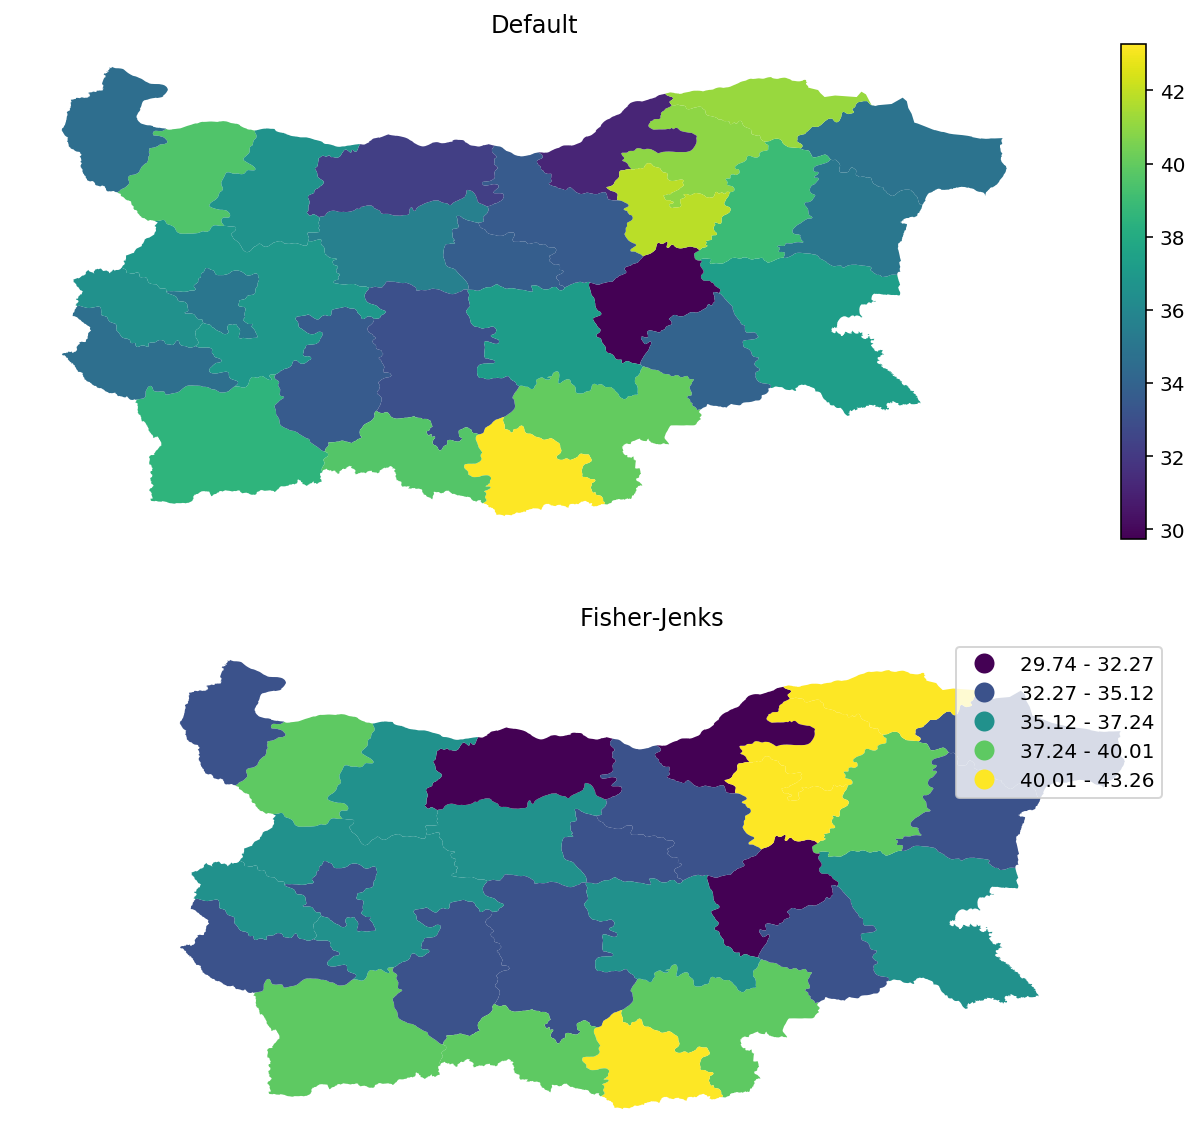

In [33]:
fig, axes = plt.subplots(2, figsize=(12, 10))

geo.plot(column='turnout', legend=True, ax=axes[0]);
axes[0].set_axis_off()
axes[0].set_title('Default')

geo.plot(column='turnout', legend=True, ax=axes[1], scheme='Fisher_Jenks');
axes[1].set_axis_off()
axes[1].set_title('Fisher-Jenks')

fig.set_facecolor('#ffffff')
#fig.savefig('../../reports/bgr_choropleth.png')